# THE Business Problem

* **Context:**
Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help
* **Objective:** To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.


# The DATA

## Import Libraries

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Library to split data 
from sklearn.model_selection import train_test_split


# Libraries to import decision tree classifier and different ensemble classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

# Libtune to tune model, get different metric scores
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score,f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans    #Import Kmeans

from scipy.stats import zscore   #import Zscore
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [5]:
#Load data
df= pd.read_excel('/content/drive/Othercomputers/My Laptop/Enhance IT docs/Clustering/Credit Card Customer Data.xlsx')

In [6]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


### Data set Information

In [92]:

# see data shape
print(f'Our dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

Our dataset has 660 rows and 7 columns.


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [94]:
df.describe()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


### Check for missing values

In [95]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'number of missing rows': df.isna().sum(),
                                 'percent_missing': percent_missing})

missing_value_df


,number of missing rows,percent_missing
Sl_No,0,0.0
Customer Key,0,0.0
Avg_Credit_Limit,0,0.0
Total_Credit_Cards,0,0.0
Total_visits_bank,0,0.0
Total_visits_online,0,0.0
Total_calls_made,0,0.0


### Checking for outliers


In [96]:
def outlier_percent(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) |(data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

In [97]:
for column in df.columns:
  dat = df[column]

  percent = str(round(outlier_percent(dat), 2))
  print(f'Outliers in "{column}": {percent}%')

Outliers in "Sl_No": 0.0%
Outliers in "Customer Key": 0.0%
Outliers in "Avg_Credit_Limit": 5.91%
Outliers in "Total_Credit_Cards": 0.0%
Outliers in "Total_visits_bank": 0.0%
Outliers in "Total_visits_online": 5.61%
Outliers in "Total_calls_made": 0.0%


In [98]:
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

##UNIVARIATE & BIVARIATE ANALYSIS

### functions for EDA

In [99]:
# User defined function to generate barplot of my variables to indicate percentage each category
# This is essential so that I do not have to repeat
# the same block of codes for each variable

## PARAM:
## plot - 
## feature - categorical feature array

def bar_by_percentage(plot, feature):
    # get length of the column
    total = len(feature)
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage

In [100]:
category_columns = df.drop(columns=['Customer Key', 'Sl_No']).columns

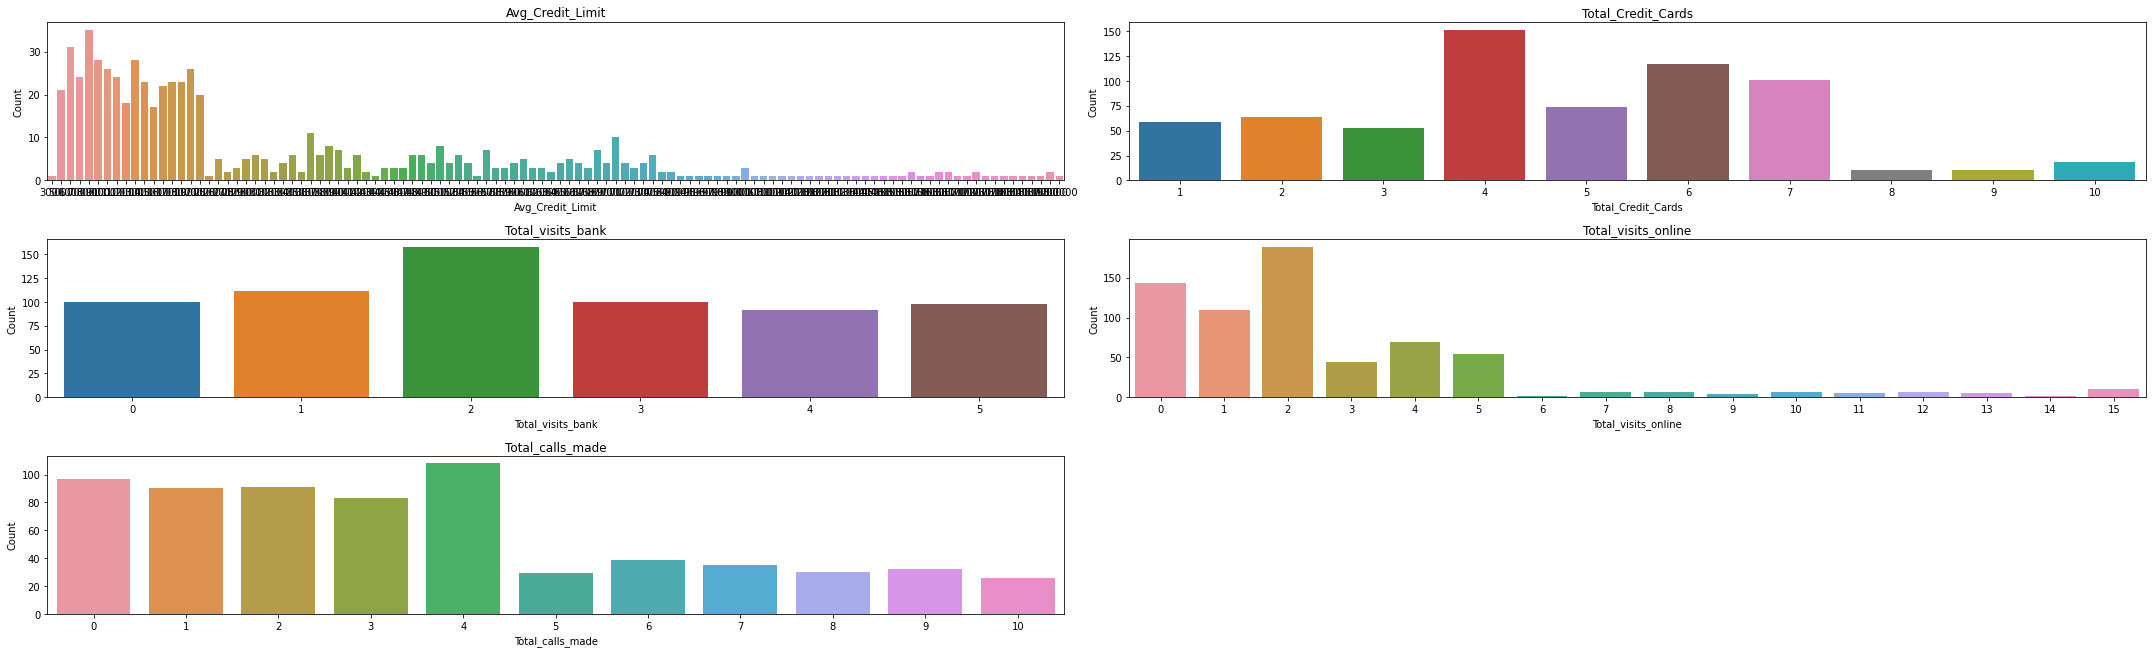

In [102]:
category_columns = df.drop(columns=['Customer Key', 'Sl_No']).columns

plt.figure(figsize=(30,90))

for i in range(len(category_columns)):
    plt.subplot(30, 2, i+1)
    ax = sns.countplot(df[category_columns[i]])
    plt.xlabel(category_columns[i])
    plt.ylabel('Count')
    #bar_by_percentage(ax, data[category_columns[i]])
    plt.tight_layout()
    plt.title(category_columns[i])
plt.savefig('count.jpeg');

* ### UNIVARIATE ANALYSIS





### Avg_Credit_Limit

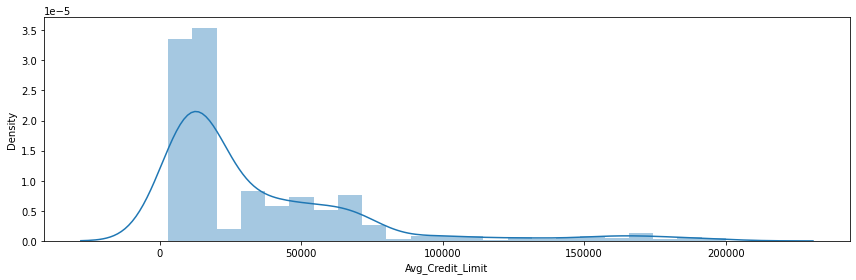

In [103]:

# a).- Avg_Credit_Limit
plt.figure(figsize=(12,4));
sns.distplot(df.Avg_Credit_Limit)
plt.savefig('avg_cred.png')

First observation on Avg_Credit_limit shows 3 clustering groups and right skew profile

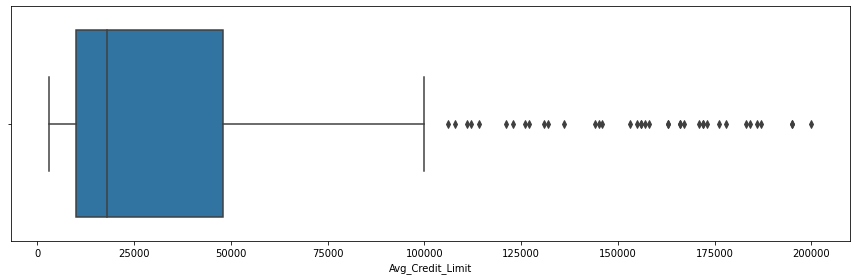

In [104]:

# a).- Avg_Credit_Limit
plt.figure(figsize=(12,4));
sns.boxplot(df.Avg_Credit_Limit)
plt.savefig('avg_cred_bx.png')

### Total_Credits_cards

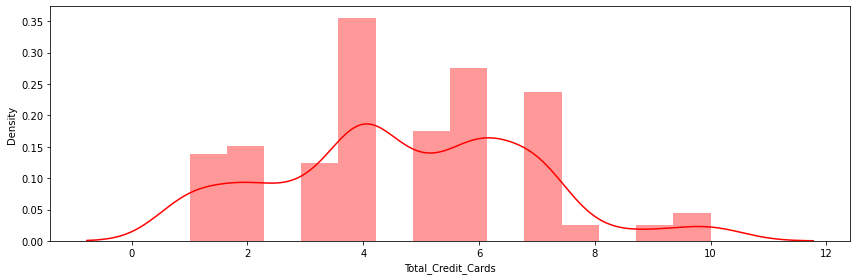

In [105]:

# b).- Total_Credits_cards
plt.figure(figsize=(12,4));
sns.distplot(df.Total_Credit_Cards, color='red')
plt.savefig('tot_cc.png')


The observation above on Total_Credit_Cards shows 4 clustering groups and not skew preference

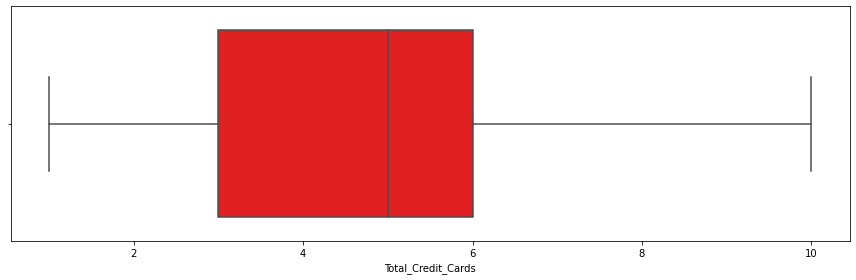

In [45]:
# b).- Total_Credit_Cards
plt.figure(figsize=(12,4));
sns.boxplot(df.Total_Credit_Cards, color='red')
plt.savefig('tot_cc_bx.png')

### Total_Credit_cards

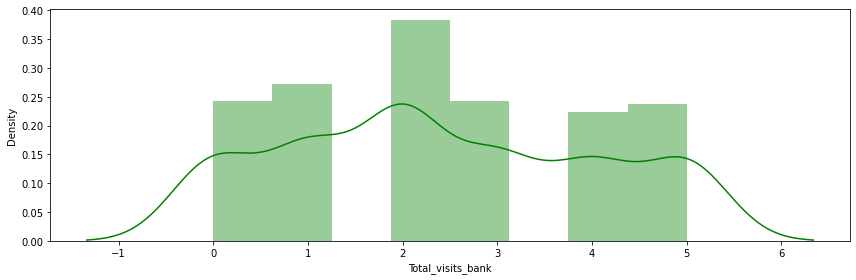

In [46]:
#c).- Total_visits to bank
plt.figure(figsize=(12,4));
sns.distplot(df.Total_visits_bank, color='green')
plt.savefig('visit_bank.png')

the observation on Total_visits_bank shows 3clustering groups and not skew preference

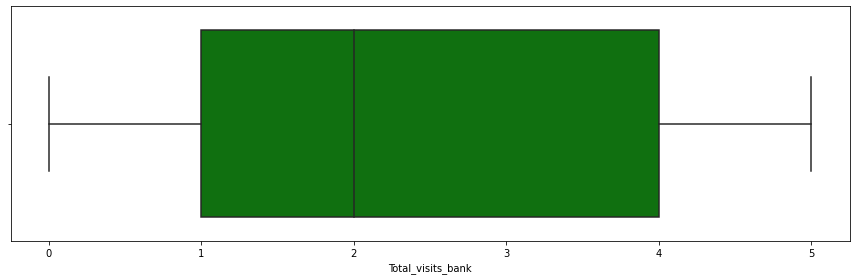

In [47]:

#c).- Total_visits_to_bank
plt.figure(figsize=(12,4));
sns.boxplot(df.Total_visits_bank, color='green')
plt.savefig('visit_bankbx.png')

### Total_visits_online

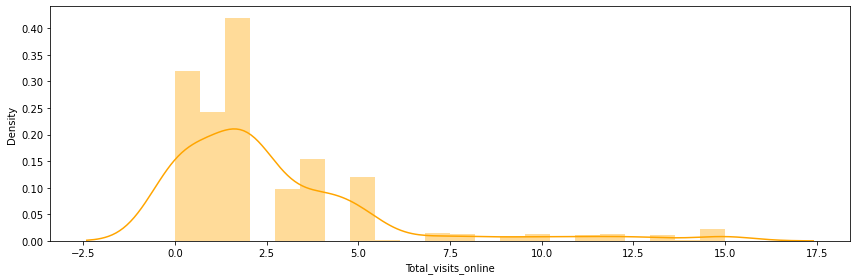

In [48]:
#d).- Total_visits_online
plt.figure(figsize=(12,4));
sns.distplot(df.Total_visits_online, color='orange')
plt.savefig('visit_online.png')

The observation above on Total_visits_online shows 3 clustering groups and right skew profile

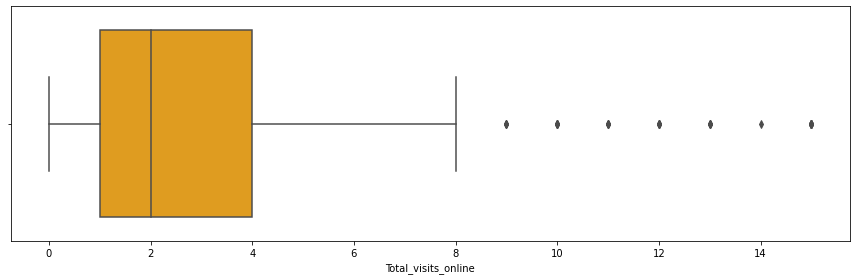

In [49]:
#d).- Total_visits_online
plt.figure(figsize=(12,4));
sns.boxplot(df.Total_visits_online, color='orange')
plt.savefig('visit_onlinebx.png')

Total_calls_made

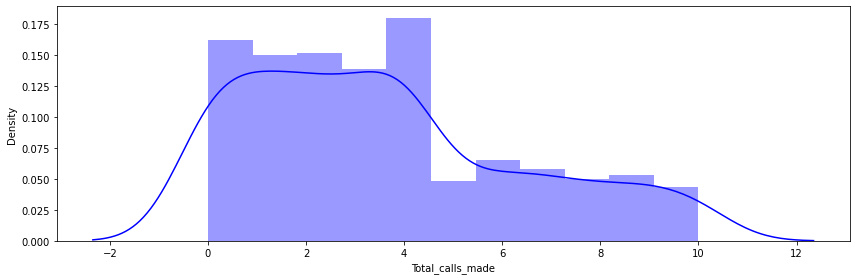

In [50]:
#e).- Total_calls_made
plt.figure(figsize=(12,4));
sns.distplot(df.Total_calls_made, color='blue')
plt.savefig('calls_made.png')


the observation on Total_calls_made shows 2 clustering groups and not skew preference

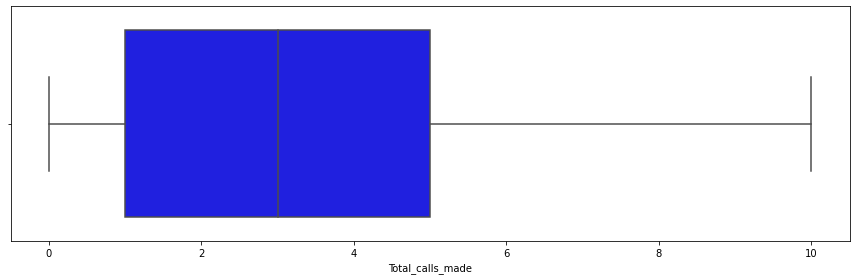

In [51]:
#e).- Total_calls_made
plt.figure(figsize=(12,4));
sns.boxplot(df.Total_calls_made, color='blue')
plt.savefig('calls_madebx.png')

* ### BIVARIATE ANALYSIS

In [7]:
# Copy data frame
df2 = df.copy()

In [8]:
df = df.drop(columns=['Sl_No','Customer Key'])
df.corr(method='kendall')

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.393034,0.082167,-0.078739,-0.326996
Total_Credit_Cards,0.393034,1.000000,0.296640,-0.242907,-0.492532
Total_visits_bank,0.082167,0.296640,1.000000,-0.512982,-0.373968
Total_visits_online,-0.078739,-0.242907,-0.512982,1.000000,0.310855
Total_calls_made,-0.326996,-0.492532,-0.373968,0.310855,1.000000


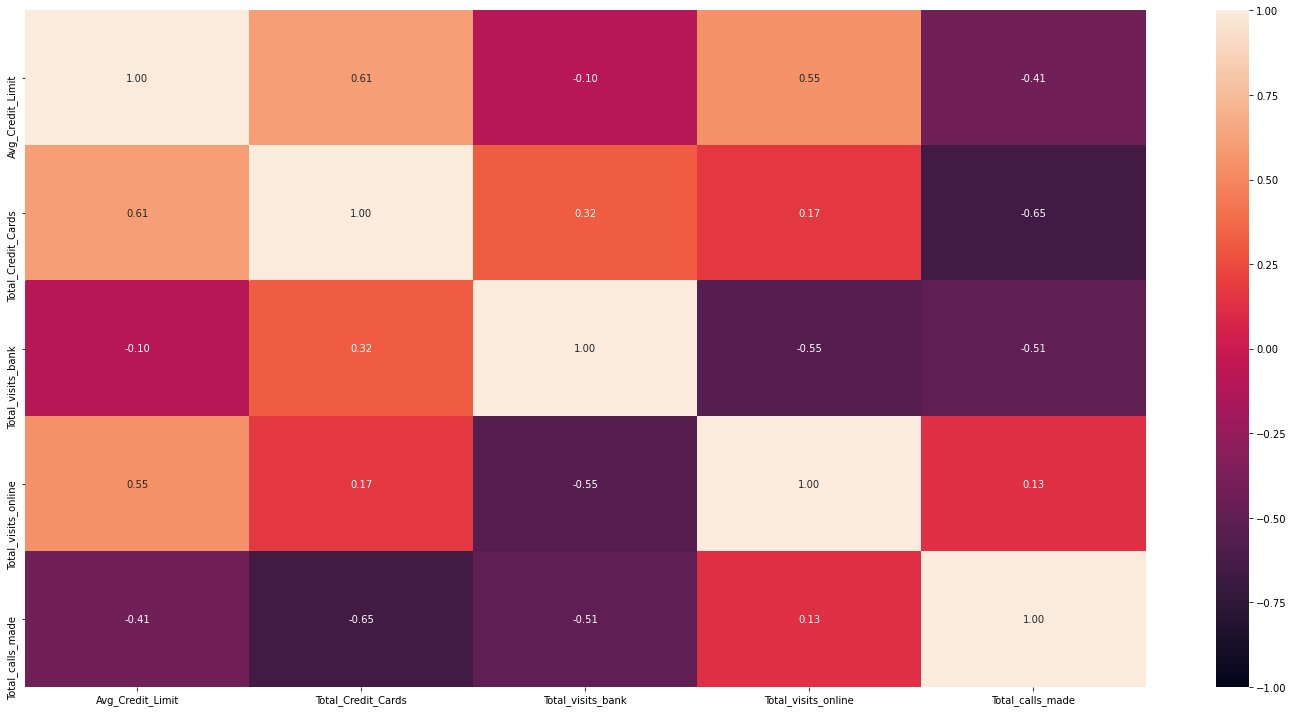

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1,fmt='.2f')
plt.savefig('corr1.png')
plt.show()

<Figure size 1440x720 with 0 Axes>

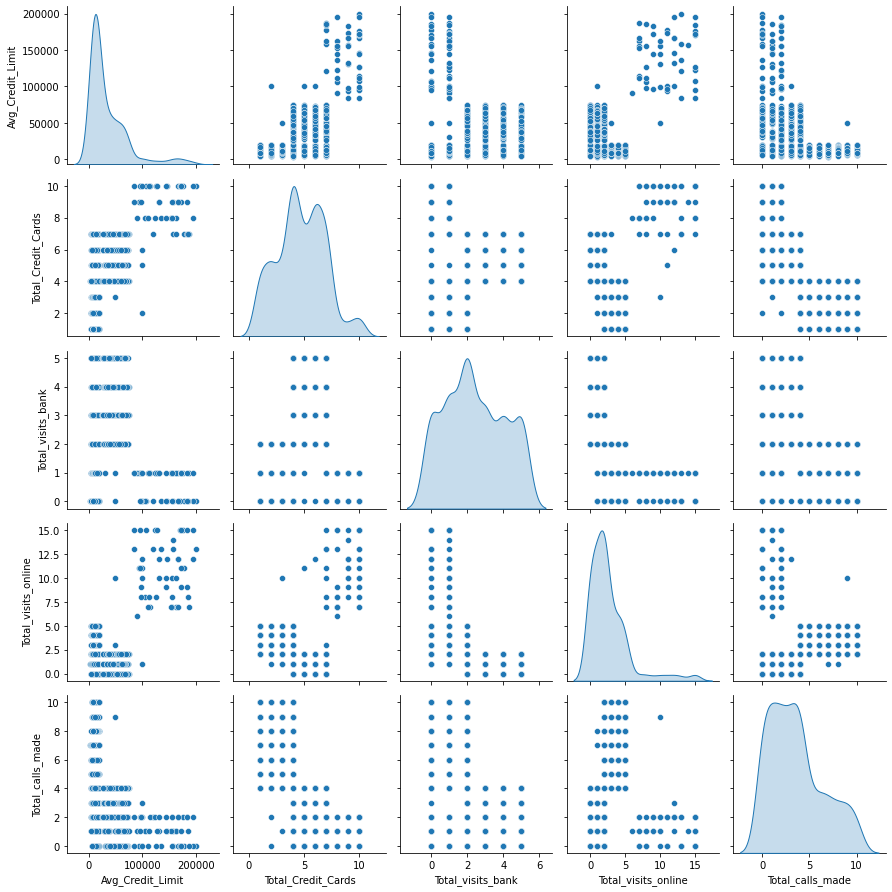

In [109]:
plt.figure(figsize=(20,10))
sns.pairplot(df, diag_kind='kde')
plt.savefig('pairplot.jpeg')

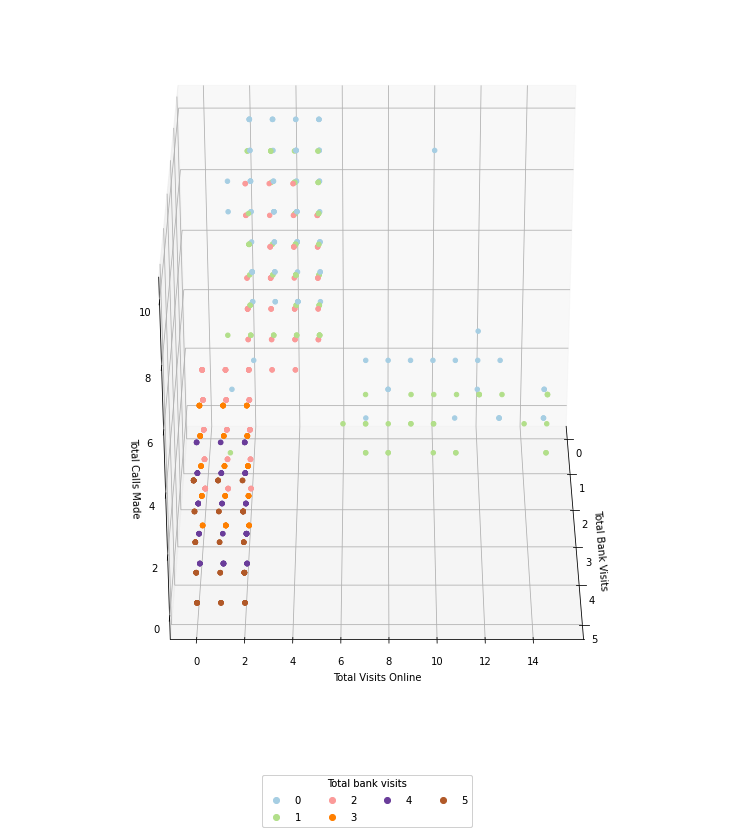

In [110]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(10,10))

ax = Axes3D(fig)



x = df.Total_visits_bank
y = df.Total_visits_online
z = df.Total_calls_made


g = ax.scatter(x, y, z, c=x, marker='o', depthshade=False, cmap='Paired')
ax.set_xlabel('Total Bank Visits')
ax.set_ylabel('Total Visits Online')
ax.set_zlabel('Total Calls Made')

# produce a legend with the unique colors from the scatter
legend = ax.legend(*g.legend_elements(), loc="lower center", title="Total bank visits", borderaxespad=-10, ncol=4)
ax.add_artist(legend)

# plt.show()

from matplotlib import animation

def rotate(angle):
     ax.view_init(azim=angle)

angle = 1
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=1)
ani.save('Cluster_plot.gif', writer=animation.PillowWriter(fps=25));

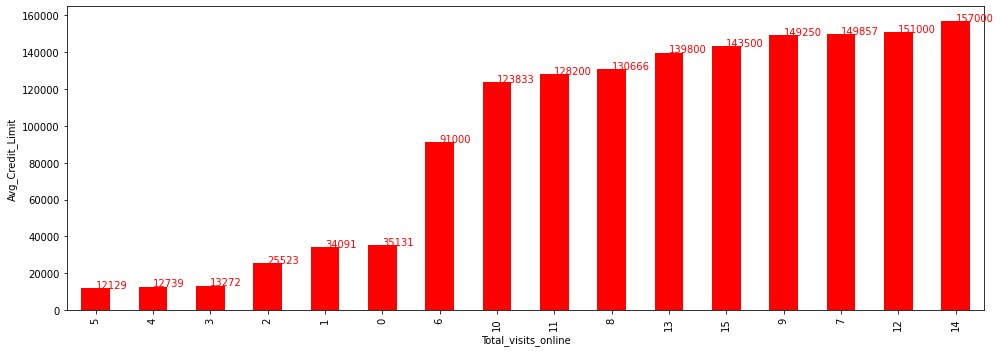

In [111]:
# Total Visits online
cust_z =df.groupby('Total_visits_online').Avg_Credit_Limit.mean().sort_values();
cust_z.plot(kind='bar',color='red', figsize=(14,5));
plt.ylabel('Avg_Credit_Limit');
for i, v in enumerate(cust_z):
    plt.text(i, v, int(v),color='r')
plt.savefig('vo_cl.png')

Group_1 < 15K, group_2 between <15k & 40K>, group_3 higher than > 90K (There is more online visit when clients have moren than >40k

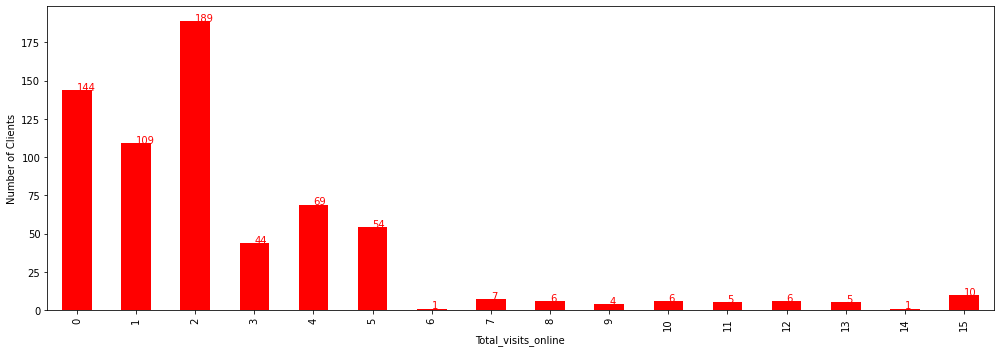

In [55]:
# Total Visits online
cust_z =df.groupby('Total_visits_online').Avg_Credit_Limit.count() #.sort_values();
cust_z.plot(kind='bar',color='red', figsize=(14,5));
plt.ylabel('Number of Clients');
for i, v in enumerate(cust_z):
    plt.text(i, v, int(v),color='r')
plt.savefig('v0_cl2.png')

In [7]:
#Total_visits_online
vo_under = df.Total_visits_online[(df.Total_visits_online>2) & (df.Total_visits_online<6)& (df.Avg_Credit_Limit<25000)].count()
print('Clients that visit online less than 3 times and have Credit_Limit < 25K :',vo_under)
#
vo_between = df.Total_visits_online[(df.Total_visits_online<3)].count()
print('Clients that visit online between 3 to 5 times and have Credit_Limit between 25K & 75K :',vo_between)
#
vo_above = df.Total_visits_online[(df.Total_visits_online>5) & (df.Avg_Credit_Limit> 75000)].count()
print('Clients that visit online more than 5 times and have Credit_Limit > 75K :',vo_above)

Clients that visit online less than 3 times and have Credit_Limit < 25K : 166
Clients that visit online between 3 to 5 times and have Credit_Limit between 25K & 75K : 442
Clients that visit online more than 5 times and have Credit_Limit > 75K : 50


In [22]:
#Avg_Credit_Limit
cl_under = df.Avg_Credit_Limit[df.Avg_Credit_Limit<25000].count()
print('Clients with Credit_Limit < 25K :',cl_under)
#
cl_between = df.Avg_Credit_Limit[(df.Avg_Credit_Limit>25000) & (df.Avg_Credit_Limit<75000)].count()
print('Clients between Credit_Limit < 25K & 75K > :',cl_between)
#
cl_above = df.Avg_Credit_Limit[df.Avg_Credit_Limit>75000].count()
print('Clients with Credit_Limit > 75K :',cl_above)

Clients with Credit_Limit < 25K : 390
Clients between Credit_Limit < 25K & 75K > : 216
Clients with Credit_Limit > 75K : 51


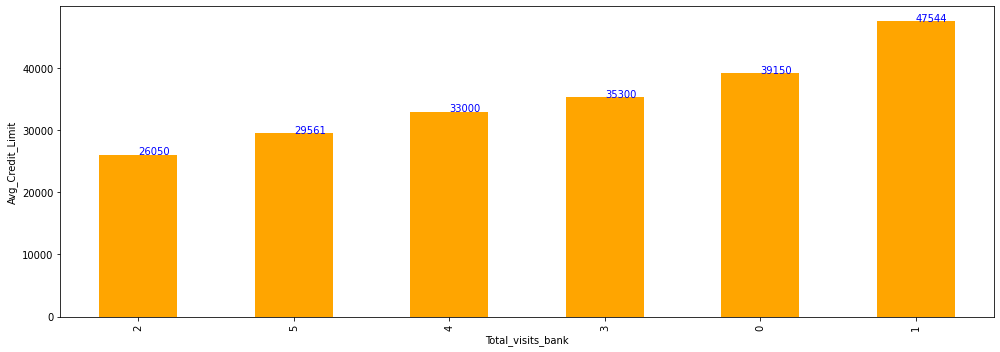

In [57]:

# Total Visits bank
cust_z =df.groupby('Total_visits_bank').Avg_Credit_Limit.mean().sort_values();
cust_z.plot(kind='bar',color='orange', figsize=(14,5));
plt.ylabel('Avg_Credit_Limit');
for i, v in enumerate(cust_z):
    plt.text(i, v, int(v),color='b')
plt.savefig('bv_cl.png')

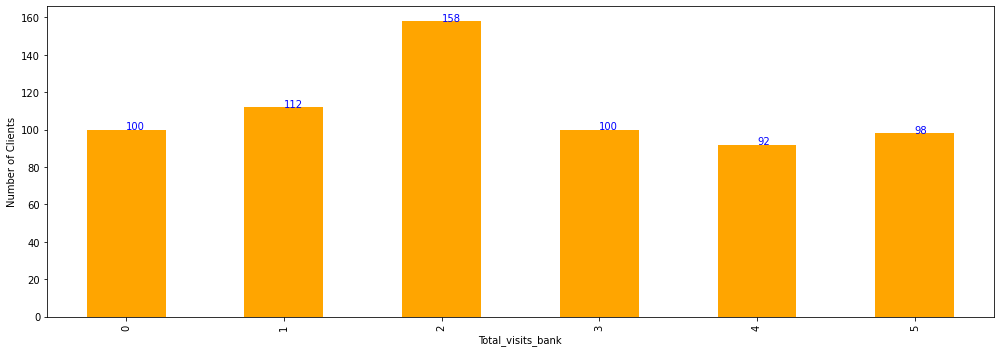

In [58]:
# Total Visits bank
cust_z =df.groupby('Total_visits_bank').Avg_Credit_Limit.count() #.sort_values();
cust_z.plot(kind='bar',color='orange', figsize=(14,5));
plt.ylabel('Number of Clients');
for i, v in enumerate(cust_z):
    plt.text(i, v, int(v),color='b')
plt.savefig('bv_cl2.png')

In [29]:
#Total_Visits_Bank
vbz = df.Total_visits_bank[df.Total_visits_bank==0].count()
print('Clients with zero visit to bank :',vbz)

Clients with zero visit to bank : 100


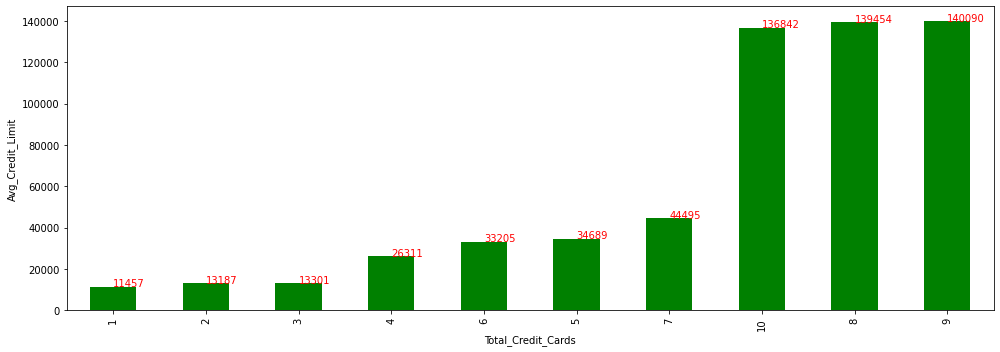

In [59]:
# Total Credit Cards
#df_in.groupby('Total_Credit_Cards').Avg_Credit_Limit.count().plot(kind='bar')
cust_z =df.groupby('Total_Credit_Cards').Avg_Credit_Limit.mean().sort_values();
cust_z.plot(kind='bar',color='g', figsize=(14,5));
plt.ylabel('Avg_Credit_Limit');
for i, v in enumerate(cust_z):
    plt.text(i, v, int(v),color='r')
plt.savefig('cc_cl.png')


the plot shows 3 groups, group_1 with salaries below 15K, group_2 with slaries between <15k & 45K>, group_3 with salaries over 100K. Higher salaries correlated with more number of credit cards

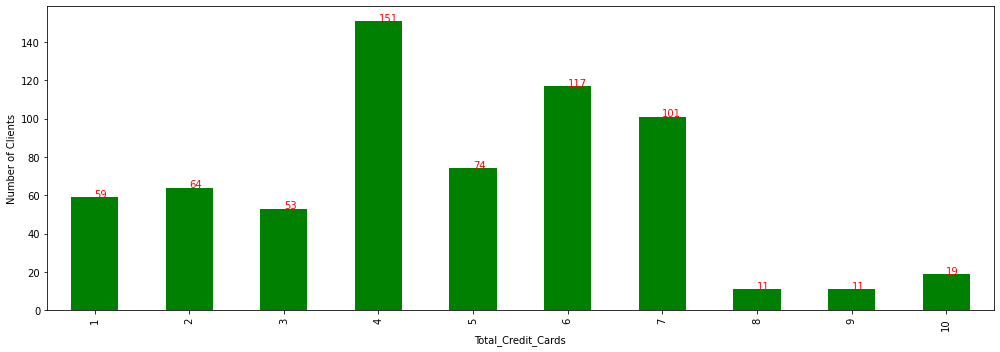

In [60]:
# Total Credit Cards
cust_z =df.groupby('Total_Credit_Cards').Avg_Credit_Limit.count() #.sort_values();
cust_z.plot(kind='bar',color='g', figsize=(14,5));
plt.ylabel('Number of Clients');
for i, v in enumerate(cust_z):
    plt.text(i, v, int(v),color='r')
plt.savefig('cc_cl2.png')

the plot shows 3 groups, group_1 with salaries below 15K, group_2 with slaries between <15k & 45K>, group_3 with salaries over 100K. Higher salaries correlated with more number of credit cards

In [25]:

#Total_Credit_Cards  
cc_under= df.Total_Credit_Cards[df.Total_Credit_Cards<4].count()
print('Clients with Total Credit_Cards less than 3 and credit limit below 25K :',cc_under)
#
cc_between = df.Total_Credit_Cards[(df.Total_Credit_Cards>3) & (df.Total_Credit_Cards<8)].count()
print('Clients with total credit card between 4 & 7 and Credit_Limit < 25K & 75K > :',cc_between)
#
cc_above = df.Total_Credit_Cards[df.Total_Credit_Cards>7].count()
print('Clients with total credit cars above 7 and Credit_Limit > 75K :',cc_above)

Clients with Total Credit_Cards less than 3 and credit limit below 25K : 176
Clients with total credit card between 4 & 7 and Credit_Limit < 25K & 75K > : 443
Clients with total credit cars above 7 and Credit_Limit > 75K : 41


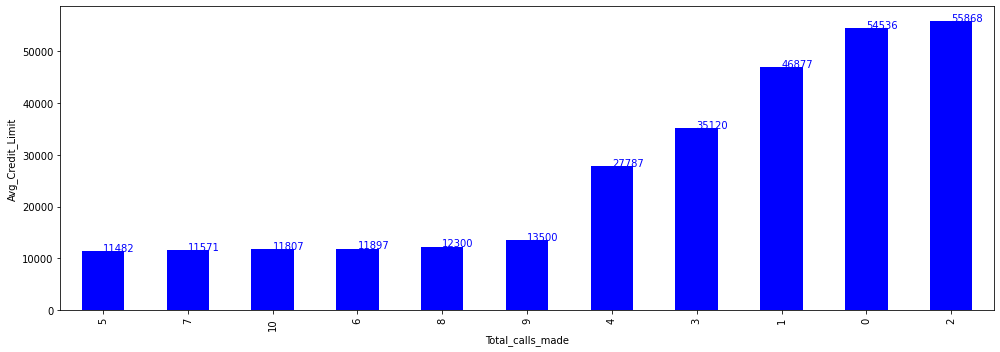

In [61]:

# Total calls made
cust_z =df.groupby('Total_calls_made').Avg_Credit_Limit.mean().sort_values();
cust_z.plot(kind='bar',color='blue', figsize=(14,5));
plt.ylabel('Avg_Credit_Limit');
for i, v in enumerate(cust_z):
    plt.text(i, v, int(v),color='b')
plt.savefig('cm_cl.png')

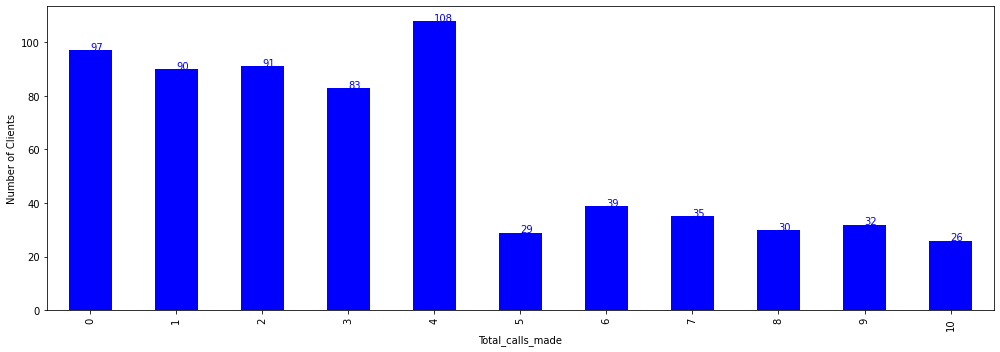

In [62]:

# Total calls made
cust_z =df.groupby('Total_calls_made').Avg_Credit_Limit.count()  #.sort_values();
cust_z.plot(kind='bar',color='blue', figsize=(14,5));
plt.ylabel('Number of Clients');
for i, v in enumerate(cust_z):
    plt.text(i, v, int(v),color='b')
plt.savefig('cm_cl2.png')

In [11]:
#Total_calls_made
cm_above = df.Total_calls_made[(df.Total_calls_made>4) & (df.Avg_Credit_Limit<25000)].count()
print('Clients that made more than 4  calls and have Credit_Limit less than Avg. 25K :',cm_above)
#
cm_below = df.Total_calls_made[(df.Total_calls_made<5) & (df.Avg_Credit_Limit>75000)].count()
print('Clients that made less than 4  calls and have Credit_Limit above than Avg. 75K :',cm_below)

Clients that made more than 4  calls and have Credit_Limit less than Avg. 25K : 190
Clients that made less than 4  calls and have Credit_Limit above than Avg. 75K : 51


## More EDA handling the outliers





In [10]:

# Feature skews
df_ske = pd.DataFrame()
for n in df:
    df_ske.loc[n,"Skew"] = df[n].skew() #df_ske.append(ske_val) 
df_ske

,Skew
Avg_Credit_Limit,2.202396
Total_Credit_Cards,0.144879
Total_visits_bank,0.141896
Total_visits_online,2.225607
Total_calls_made,0.658905


In [11]:
# changing zero in Total_visits_online to 0 to 1 before to tranform to log
df.Total_visits_online[df.Total_visits_online==0] = 1

In [12]:
# Let us take logaritmic transform for Avg_Credit_limit & Total_visits_online to remove outliers
df['Avg_Credit_Limit'] = np.log(df['Avg_Credit_Limit'])
df['Total_visits_online'] = np.log(df['Total_visits_online'])
#
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,11.512925,2,1,0.000000,0
1,10.819778,3,0,2.302585,9
2,10.819778,7,1,1.098612,4
3,10.308953,5,1,0.000000,4
4,11.512925,6,0,2.484907,3


In [13]:
df_ske = pd.DataFrame()
for n in df:
    df_ske.loc[n,"Skew"] = df[n].skew() #df_ske.append(ske_val) 
df_ske

,Skew
Avg_Credit_Limit,0.393753
Total_Credit_Cards,0.144879
Total_visits_bank,0.141896
Total_visits_online,0.766719
Total_calls_made,0.658905


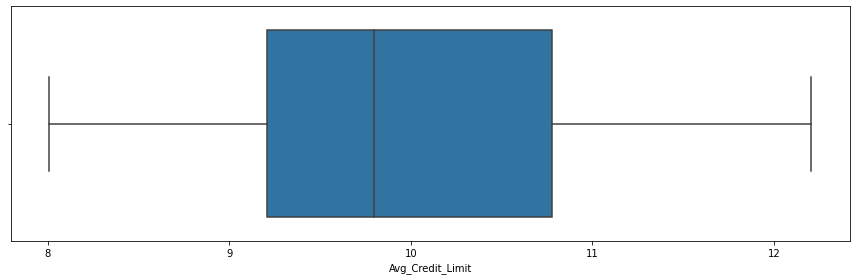

In [14]:
# a).- Avg_Credit_Limit
plt.figure(figsize=(12,4));
sns.boxplot(df.Avg_Credit_Limit);

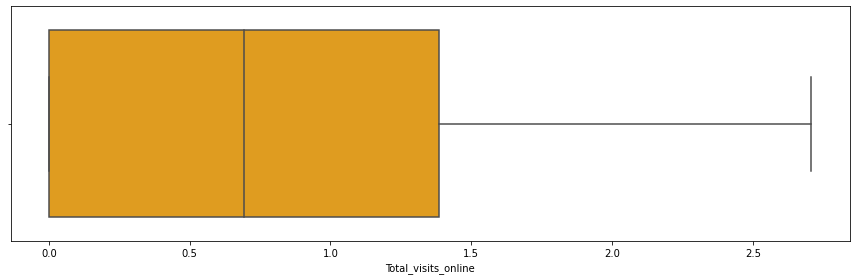

In [15]:
#d).- Total_visits_online
plt.figure(figsize=(12,4));
sns.boxplot(df.Total_visits_online, color='orange');

In [16]:
# This looks better.
# Now let us try to scale the variables
from scipy.stats import zscore

df.dtypes
numeric_cols = df.select_dtypes(include=[np.int64, np.float64]).columns
numeric_cols
df[numeric_cols] = df[numeric_cols].apply(zscore)

In [17]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.630478,-1.249225,-0.860451,-1.001984,-1.251537
1,0.885387,-0.787585,-1.473731,2.158203,1.891859
2,0.885387,1.058973,-0.860451,0.505809,0.145528
3,0.336281,0.135694,-0.860451,-1.001984,0.145528
4,1.630478,0.597334,-1.473731,2.408431,-0.203739


#  K-means clustering

In [18]:
# Variables are mow scaled. Let us now try to create clusters
cluster_range = range(1,15)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters, n_init = 5)
    clusters.fit(df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})
clusters_df.set_index('num_clusters',inplace=True)
clusters_df

,cluster_errors
num_clusters,
1,3300.000000
2,1872.566365
3,1117.394240
4,887.700142
5,801.969686
6,725.648804
7,659.492570
8,632.324865
9,603.909951


In [19]:

clusters

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=14, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

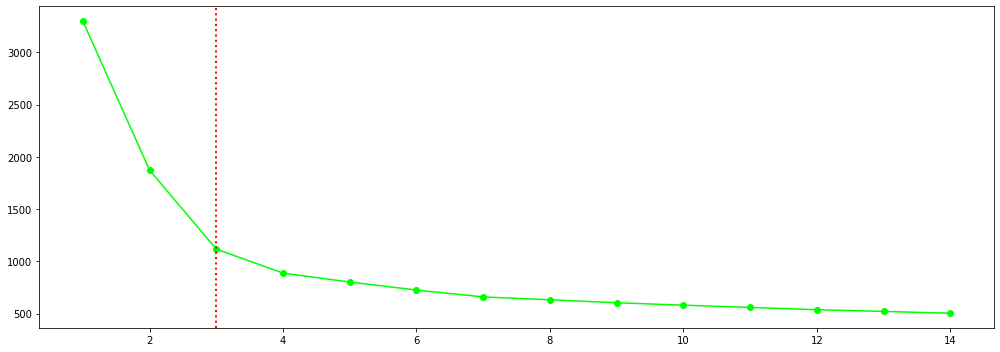

In [20]:
# Elbow plot
from matplotlib import cm

plt.figure(figsize=(14,5));
plt.plot( clusters_df.index, clusters_df.cluster_errors, marker = "o", color='lime')
# only one line may be specified; full height
plt.axvline(x=3, color='r', label='axvline - full height', ls=':', lw=2 )
plt.savefig('elbowplt.png')

From the curve, we can see inflexion point at 3 clusters

In [21]:

# We could see the bend at 3, so let us create 3 clusters
n_cl = 3
kmeans = KMeans(n_clusters=n_cl, n_init = 5, random_state=12345)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=12345, tol=0.0001, verbose=0)

In [22]:

kmeans.fit_transform(df)

array([[4.51914728, 3.76088408, 2.77048142],
       [3.99777611, 2.41506283, 4.51641341],
       [2.42419306, 2.85062181, 2.27485603],
       ...,
       [0.47666279, 4.51004965, 3.79613978],
       [0.91631943, 5.5635893 , 4.76625279],
       [0.57646353, 4.90333897, 4.54652851]])

In [23]:
# Check the number of data in each cluster
labels = kmeans.labels_
counts = np.bincount(labels[labels>=0])
print(counts)

[ 50 224 386]


In [24]:

# Distribution looks fine.

# let us check the centers in each group
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df) )
centroid_df.transpose()

,0,1,2
Avg_Credit_Limit,1.966490,-0.732429,0.170310
Total_Credit_Cards,1.862226,-1.055501,0.371298
Total_visits_bank,-1.105763,-0.896043,0.663217
Total_visits_online,2.226979,0.653720,-0.667829
Total_calls_made,-0.874330,1.152786,-0.555719


In [25]:
# study the characteristics for each group K-Means
predictions = kmeans.predict(df)
predictions
df["group"] = predictions

0 Avg_Credit_Limit 0
1.966489963099485
0 Avg_Credit_Limit 1
-0.7324288103796887
0 Avg_Credit_Limit 2
0.17030972893801882
1 Total_Credit_Cards 0
1.8622262060480952
1 Total_Credit_Cards 1
-1.055500996471365
1 Total_Credit_Cards 2
0.37129770183207556
2 Total_visits_bank 0
-1.1057626863991186
2 Total_visits_bank 1
-0.896042779535396
2 Total_visits_bank 2
0.6632168832535883
3 Total_visits_online 0
2.226978687835302
3 Total_visits_online 1
0.6537198679804097
3 Total_visits_online 2
-0.667829494350719
4 Total_calls_made 0
-0.8743298264156562
4 Total_calls_made 1
1.1527864959755587
4 Total_calls_made 2
-0.5557193880252397


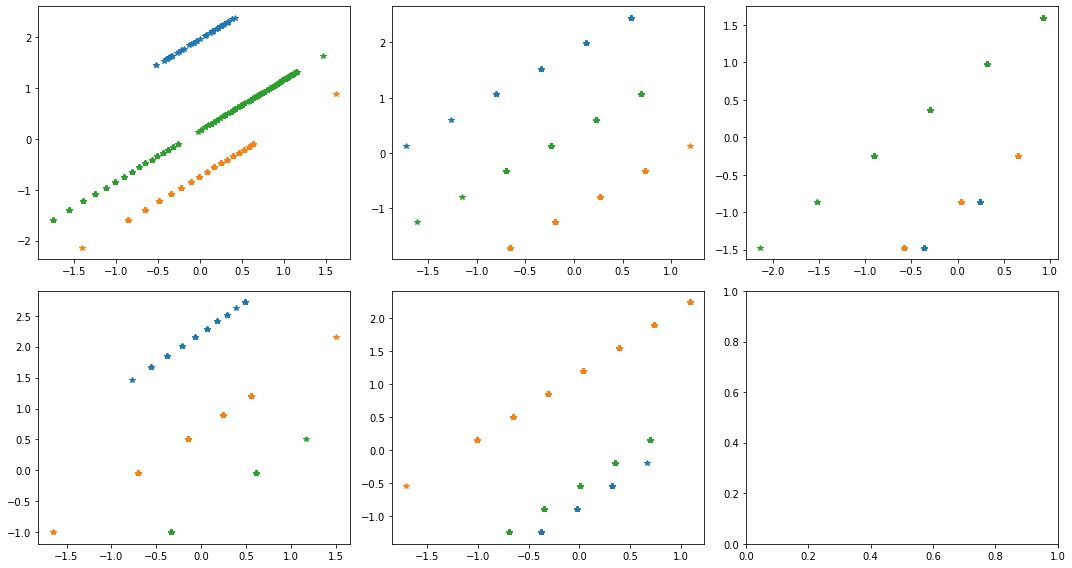

In [26]:
# Figures that not show the last column "group"
col = df.columns[0:-1]
fig, ax = plt.subplots(2,3,figsize=(15,8))
ax = np.ravel(ax)

for ii,n in enumerate(col):
    for i in range(n_cl):
        print(ii,n,i)
        print(centroids[i,ii])
        #ax[ii].plot(df[df.group==i].index, df[df.group==i][n],'*');
        ax[ii].plot(df[df.group==i][n]-centroids[i,ii], df[df.group==i][n],'*');

plt.show()

## Visualizing the clusters

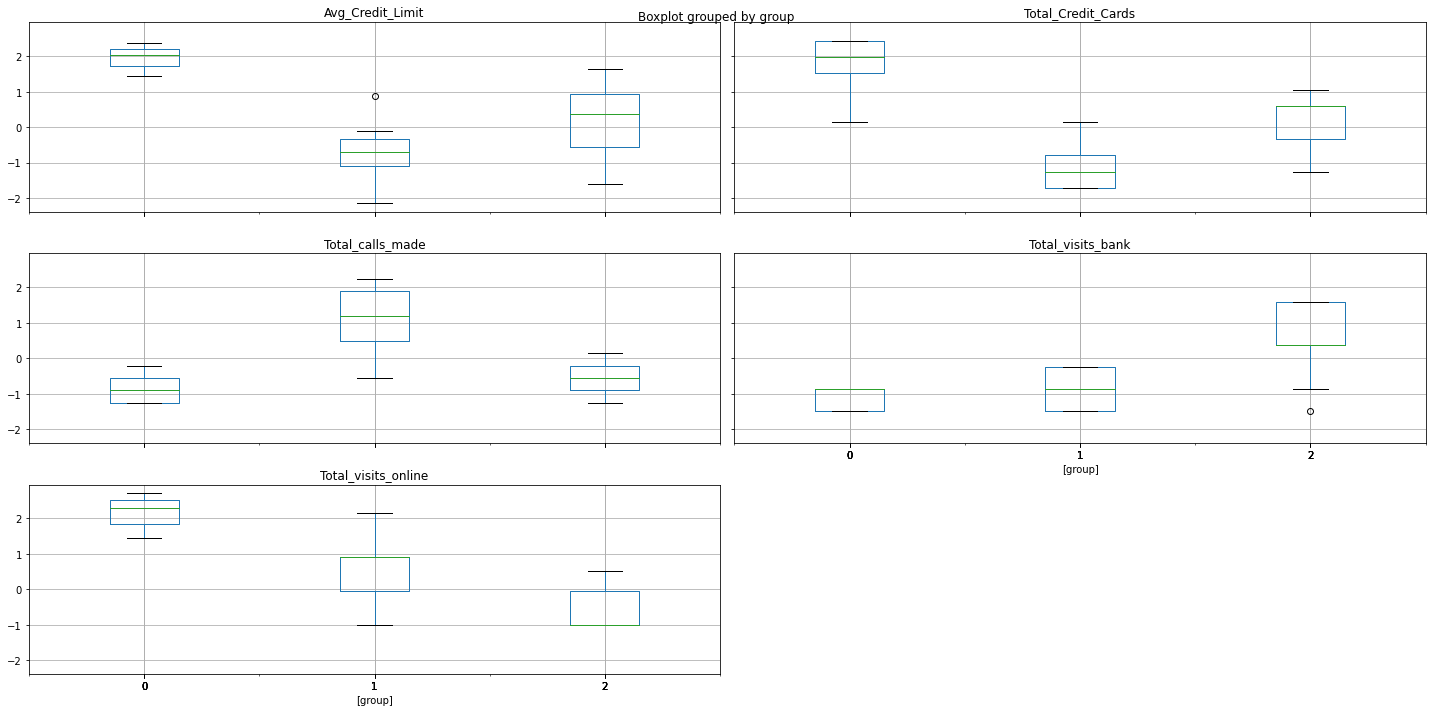

In [27]:
# Visualize the centers
df.boxplot(by = 'group',  layout=(3,2), figsize=(20, 10 ))
plt.savefig('visualizecenters.png')

correlate higher centroide ~2 (blue color) between the features Avg_Credit_Limit, Total_Credit_Cards, and Total_visits_online and lower centroide ~1 with Total_calls_made and Total_visits_bank

# Execute Hierarchical clustering (with different linkages)

with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot

In [28]:
#### generate the linkage matrix
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

In [29]:
# dropping column group adde above
df=df.drop(columns='group')

In [30]:

df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.630478,-1.249225,-0.860451,-1.001984,-1.251537
1,0.885387,-0.787585,-1.473731,2.158203,1.891859
2,0.885387,1.058973,-0.860451,0.505809,0.145528
3,0.336281,0.135694,-0.860451,-1.001984,0.145528
4,1.630478,0.597334,-1.473731,2.408431,-0.203739


### Use ward as linkage metric and distance as Eucledian

In [31]:

#Use ward as linkage metric and distance as Eucledian
Z = linkage(df, 
            method = 'ward', 
            metric='euclidean')
distance_between_pair_of_points = pdist(df)
cophenet_Z = cophenet(Z)
cop_c41 = pearsonr(cophenet(Z), distance_between_pair_of_points)[0]
cop_c41



0.780002231073503

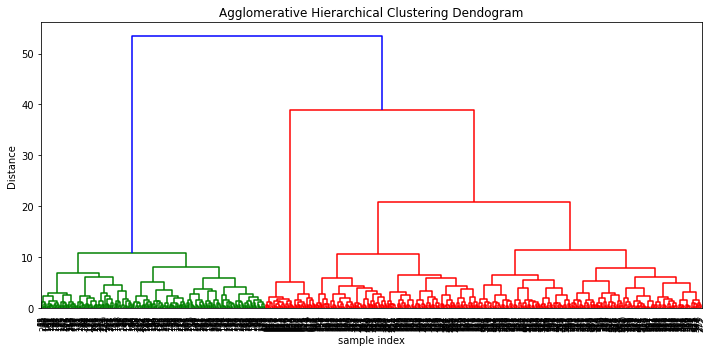

In [144]:

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()
plt.savefig('wardeucledian.png')

### Use complete as linkage metric and distance as Eucledian





In [32]:

Z = linkage(df,
            method = 'complete',
            metric='euclidean')
distance_between_pair_of_points = pdist(df)
cophenet_Z = cophenet(Z)
cop_c42 = pearsonr(cophenet(Z), distance_between_pair_of_points)[0]
cop_c42

0.8356322694421622

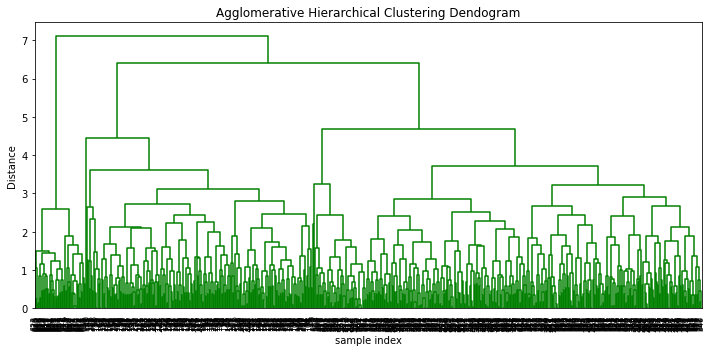

In [146]:

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()
plt.savefig('linkeuc.png')

### Use centroid as linkage metric and distance as Eucledian

In [33]:

Z = linkage(df,
            method = 'centroid',
            metric='euclidean')
distance_between_pair_of_points = pdist(df)
cophenet_Z = cophenet(Z)
cop_c43 = pearsonr(cophenet(Z), distance_between_pair_of_points)[0]
cop_c43

0.865521384623019

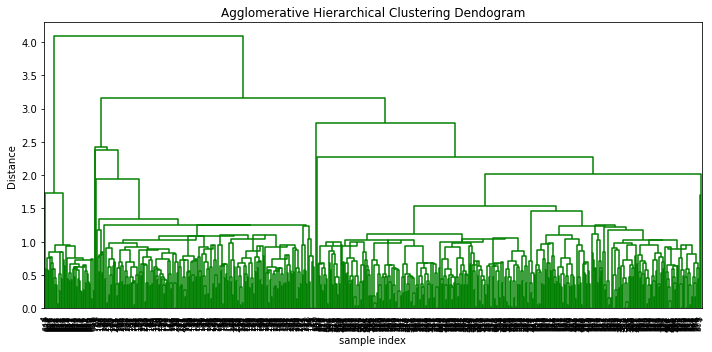

In [148]:

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()
plt.savefig('centeuc.png')

### Use median as linkage metric and distance as Eucledian

In [34]:
Z = linkage(df,
            method = 'median',
            metric='euclidean')
distance_between_pair_of_points = pdist(df)
cophenet_Z = cophenet(Z)
cop_c44 = pearsonr(cophenet(Z), distance_between_pair_of_points)[0]
cop_c44

0.8127296464583338

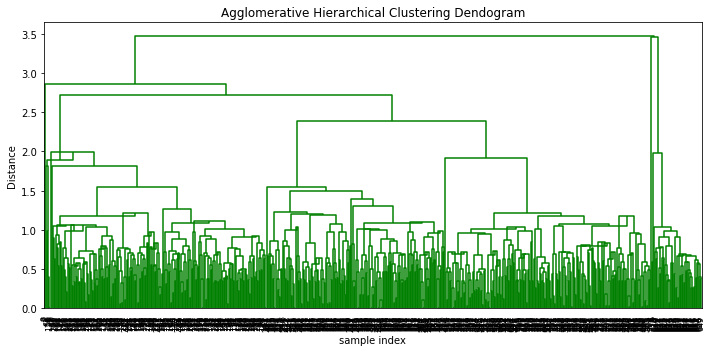

In [150]:

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8.,  )
plt.tight_layout()
plt.savefig('medeuc.png')

### Use single as linkage metric and distance as Eucledian

In [35]:
Z = linkage(df,
            method = 'single',
            metric='euclidean')
distance_between_pair_of_points = pdist(df)
cophenet_Z = cophenet(Z)
cop_c45 = pearsonr(cophenet(Z), distance_between_pair_of_points)[0]
cop_c45

0.6736393748401661

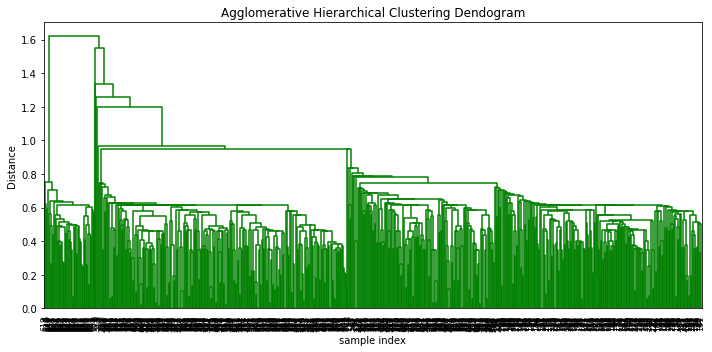

In [152]:

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()
plt.savefig('singleuc.png')

### Use average as linkage metric and distance as Eucledian

In [36]:
Z = linkage(df,
            method = 'average',
            metric='euclidean')
distance_between_pair_of_points = pdist(df)
cophenet_Z = cophenet(Z)
cop_c46 = pearsonr(cophenet(Z), distance_between_pair_of_points)[0]
cop_c46

0.8658695501958381

In [154]:
Z[:]

array([[ 464.        ,  497.        ,    0.        ,    2.        ],
       [ 425.        ,  455.        ,    0.        ,    2.        ],
       [ 437.        ,  544.        ,    0.        ,    2.        ],
       ...,
       [1311.        , 1312.        ,    2.94197696,  385.        ],
       [1315.        , 1316.        ,    3.58101342,  609.        ],
       [1313.        , 1317.        ,    4.54817422,  660.        ]])

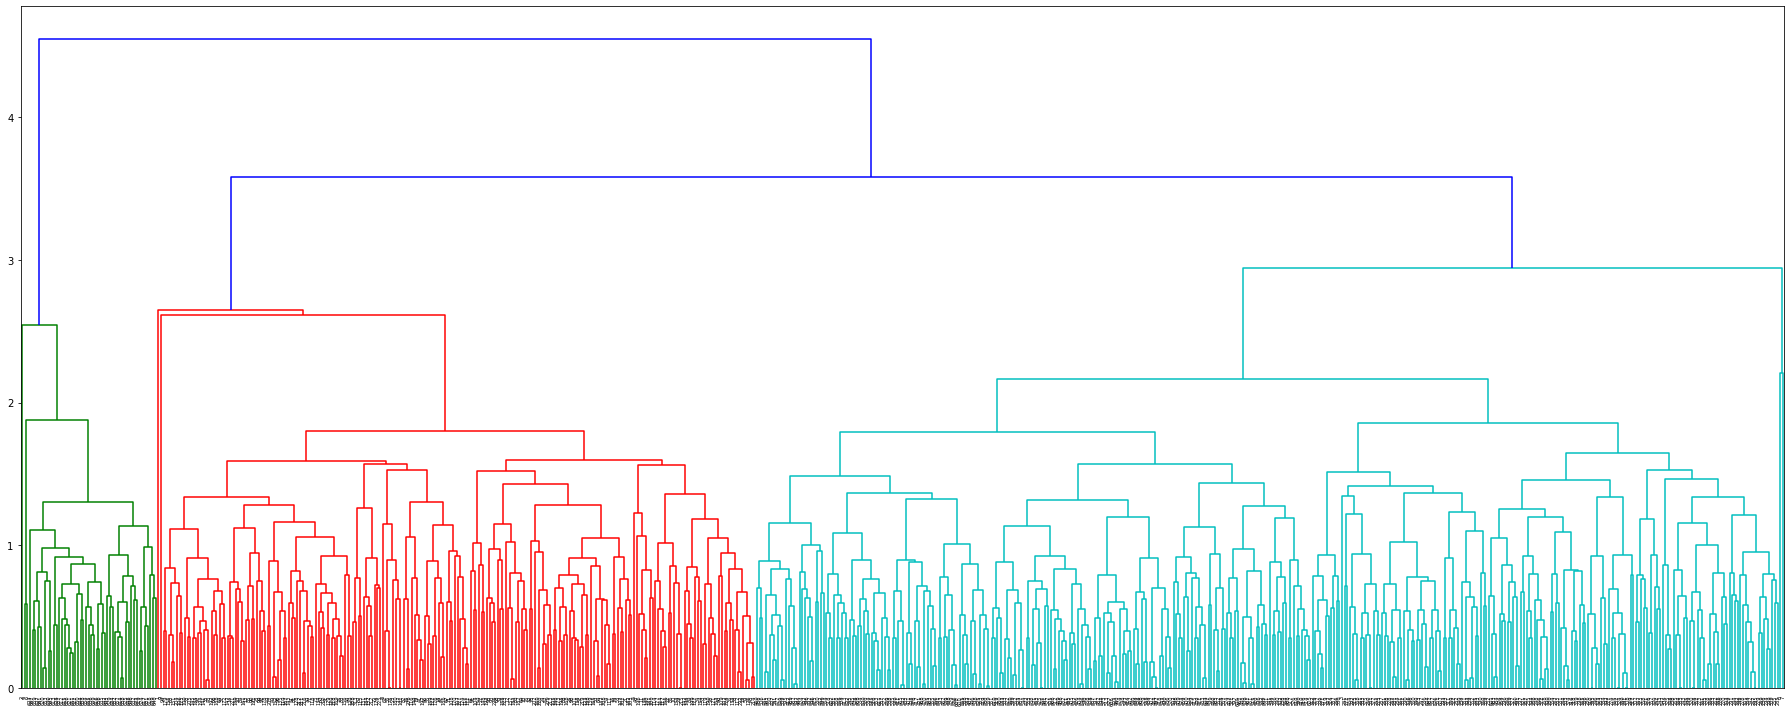

In [48]:
plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.savefig('avgeuc.png')
plt.show()

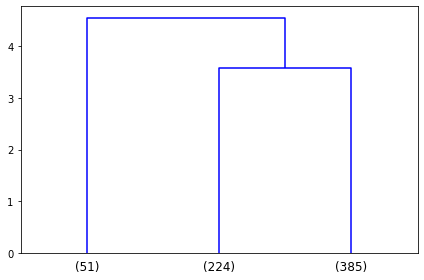

In [49]:
# Hint: Use truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,  # show only the last p merged clusters, Top 3
)
plt.savefig('lastp.png')
plt.show()

In [37]:
# Cophenetic coefficient
cophenet_Z[0:10]

array([3.58101342, 4.54817422, 2.94197696, 4.54817422, 3.58101342,
       4.54817422, 2.20678538, 3.58101342, 3.58101342, 3.58101342])

In [38]:

# Summary of method and Metric
Summary4 = pd.DataFrame({'Method & Metric':['Ward & Euclidian', 'Complete & Euclidian','Centroid & Euclidian',
                                            'Median & Euclidian', 'Single & Euclidian','Average & Euclidian' ], 
                         'Cophenet Corr':  [cop_c41, cop_c42, cop_c43,cop_c44, cop_c45, cop_c46]})
                         
Summary4

,Method & Metric,Cophenet Corr
0,Ward & Euclidian,0.780002
1,Complete & Euclidian,0.835632
2,Centroid & Euclidian,0.865521
3,Median & Euclidian,0.812730
4,Single & Euclidian,0.673639
5,Average & Euclidian,0.865870



**Summary**

average + euclidean seems to be the best

## Calculate average silhouette score for both methods

In [39]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples,silhouette_score
from collections import Counter

import matplotlib.cm as cm
import numpy as np

 Using Hierarchical Method

In [40]:
for i in range(2,10):
    ac_cluster = AgglomerativeClustering(n_clusters=i,
                                        linkage='average',
                                        affinity='euclidean')
    cluster_labels = ac_cluster.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    print(f"cluster size: {i} : {silhouette_avg}")

cluster size: 2 : 0.4369171585572219
cluster size: 3 : 0.5024231220497855
cluster size: 4 : 0.41749684634530715
cluster size: 5 : 0.36238828707888104
cluster size: 6 : 0.3352134493185991
cluster size: 7 : 0.25618601285618875
cluster size: 8 : 0.22848548721089065
cluster size: 9 : 0.23013606101235917


In [41]:

# Using 3 clusters
n_cl = 3
ac_cluster = AgglomerativeClustering(n_clusters=n_cl,
                                        linkage='average',
                                        affinity='euclidean')
cluster_labels = ac_cluster.fit_predict(df)
silhouette_avg = silhouette_score(df, cluster_labels)
print(f"cluster size 3: {silhouette_avg}")

cluster size 3: 0.5024231220497855


In [42]:

# Clients in each Cluster
Counter(cluster_labels)

Counter({0: 385, 1: 51, 2: 224})

In [43]:
# copy initial data
df_h = df.copy()
# study the characteristics for each group Hierarchical
df_h["group"] = cluster_labels
df_h['group'] = df_h['group'].astype('category')
df_h.dtypes

Avg_Credit_Limit        float64
Total_Credit_Cards      float64
Total_visits_bank       float64
Total_visits_online     float64
Total_calls_made        float64
group                  category
dtype: object


**Cluster size : 3, gives the higher value**

Using K-Means Method

In [44]:

kmeans = KMeans(n_clusters=n_cl, n_init = 5, random_state=12345)
cluster_labels52 = kmeans.fit_predict(df)
print('Clients in each cluster :')
Counter(cluster_labels52)

Clients in each cluster :


Counter({0: 50, 1: 224, 2: 386})

In [45]:

silhouette_avg52 = silhouette_score(df, cluster_labels52)
silhouette_avg52

0.5028800425917159


Both methods Hierarchical and K-Means almost the same silhouette scores

For n_clusters = 2 The average silhouette_score is : 0.424568484239482
For n_clusters = 3 The average silhouette_score is : 0.5028800425917159
For n_clusters = 4 The average silhouette_score is : 0.38562324585868046
For n_clusters = 5 The average silhouette_score is : 0.3507007736711299


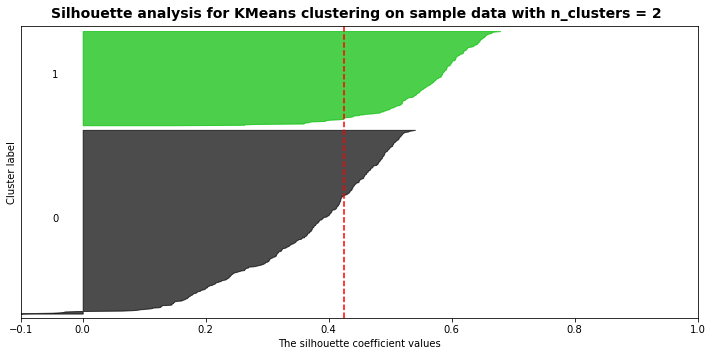

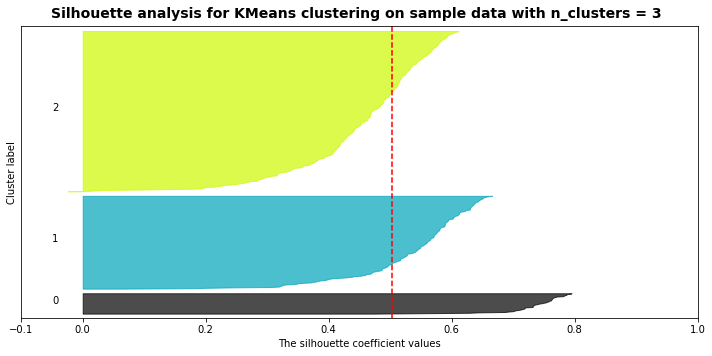

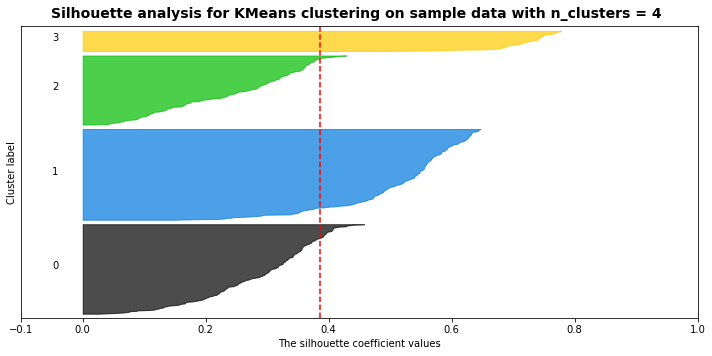

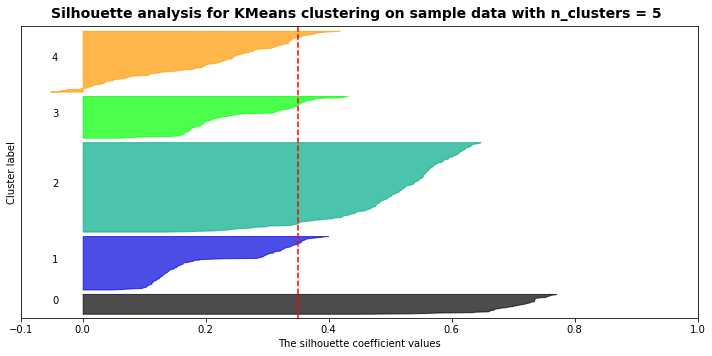

In [47]:
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots()
    fig.set_size_inches(10, 5)
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init = 5, random_state=12345)
    cluster_labels = clusterer.fit_predict(df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("                                     ")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
   
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    

    plt.savefig('silhoutte'+ str( n_clusters)+'.png')
plt.show()

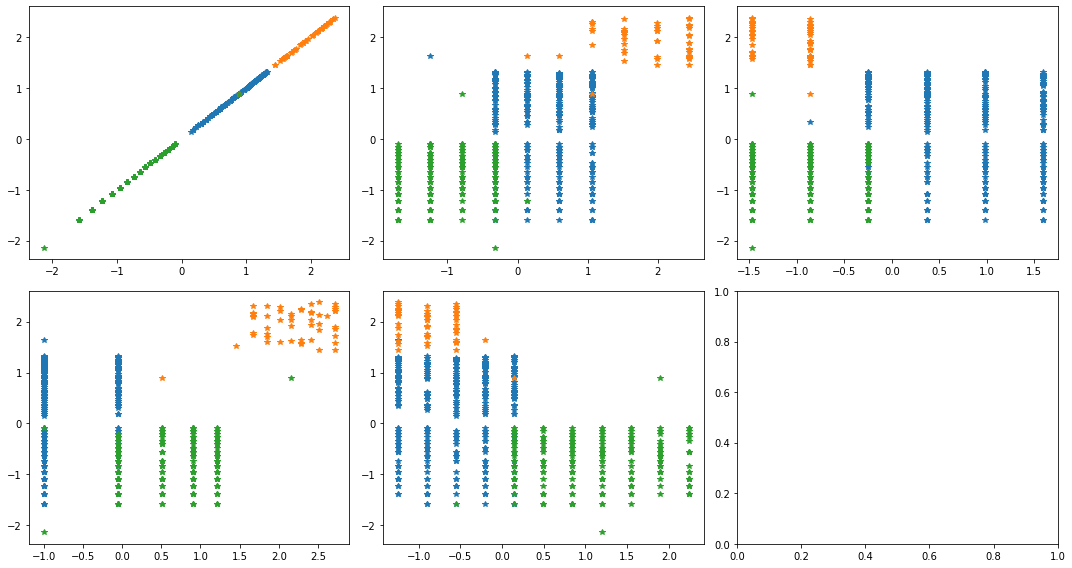

In [50]:
# Figures that not show the last column "group"
col = df_h.columns[0:-1]
fig, ax = plt.subplots(2,3,figsize=(15,8))
ax = np.ravel(ax)

for ii,n in enumerate(col):
    for i in range(n_cl):
        #ax[ii].plot(df_h[df_h.group==i].index, df_h[df_h.group==i][n],'*');
        ax[ii].plot(df_h[df_h.group==i][n], df_h[df_h.group==i].Avg_Credit_Limit,'*');

plt.show()

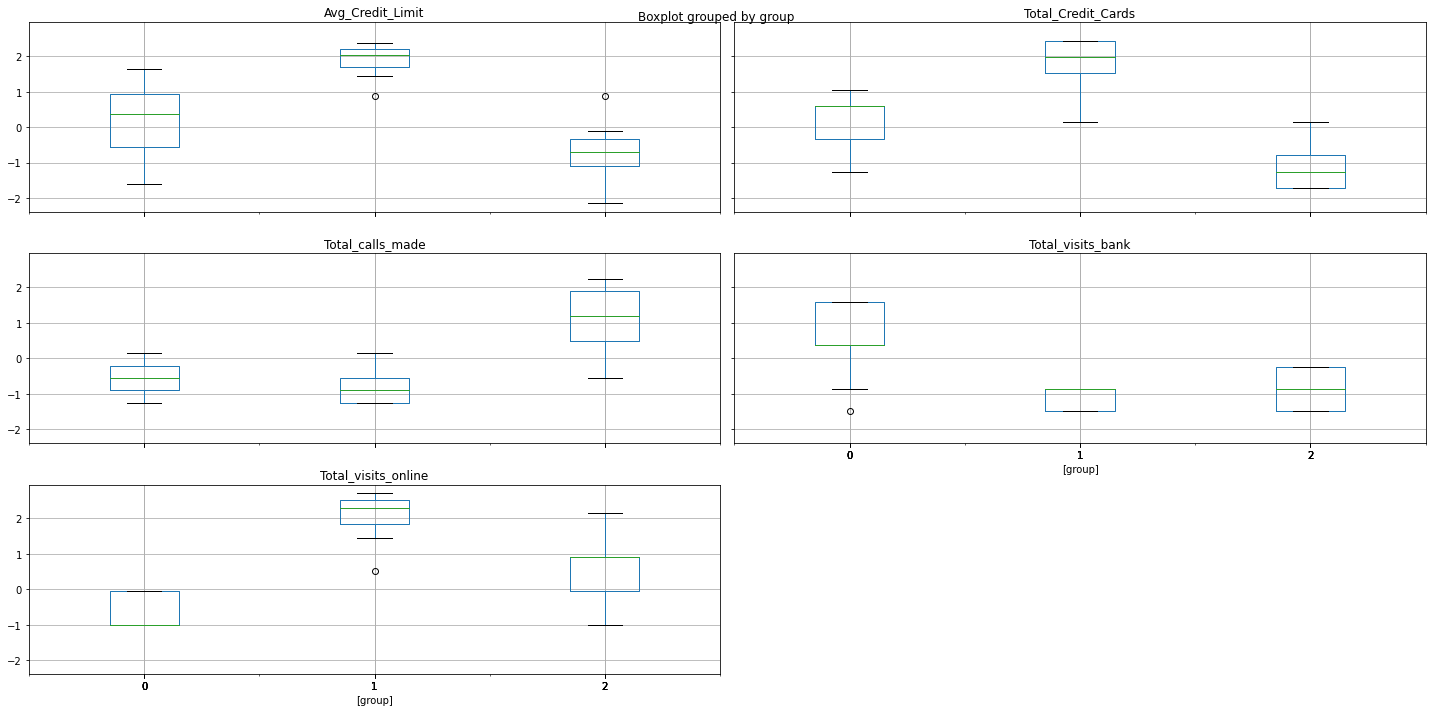

In [179]:

df_h.boxplot(by = 'group',  layout=(3,2), figsize=(20, 10) )
plt.savefig('centregrouphc.png')

Analysis the clusters formed
tell us how is one cluster different from another

* Cluster 1
This cluster is formed by clients with the highest credit limit and higher number of credit cards. They check more frequently their account online comparing with thwo other groups. Looks like they have less time for visit and calling the bank. The percent of this clients is 7.6% (50/660)

* Cluster 2
This cluster is formed by clients with the lowes credit limit and lower number of credit cards. They spend more time calling the bank than visiting or checking online. The percent of this clients is 58.3% (385/660)

* Cluster 0
This cluster is formed by middle class. They prefer to visit the bank than checking online comparing with the other clusters. Their credit limit and credit cards is middle level comparing with the other two clusters. The percent of this clients is 34.1% (225/660)

# PCA

In [53]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


In [54]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.630478,-1.249225,-0.860451,-1.001984,-1.251537
1,0.885387,-0.787585,-1.473731,2.158203,1.891859
2,0.885387,1.058973,-0.860451,0.505809,0.145528
3,0.336281,0.135694,-0.860451,-1.001984,0.145528
4,1.630478,0.597334,-1.473731,2.408431,-0.203739


In [55]:
dist = 1 - cosine_similarity(df)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(660, 2)

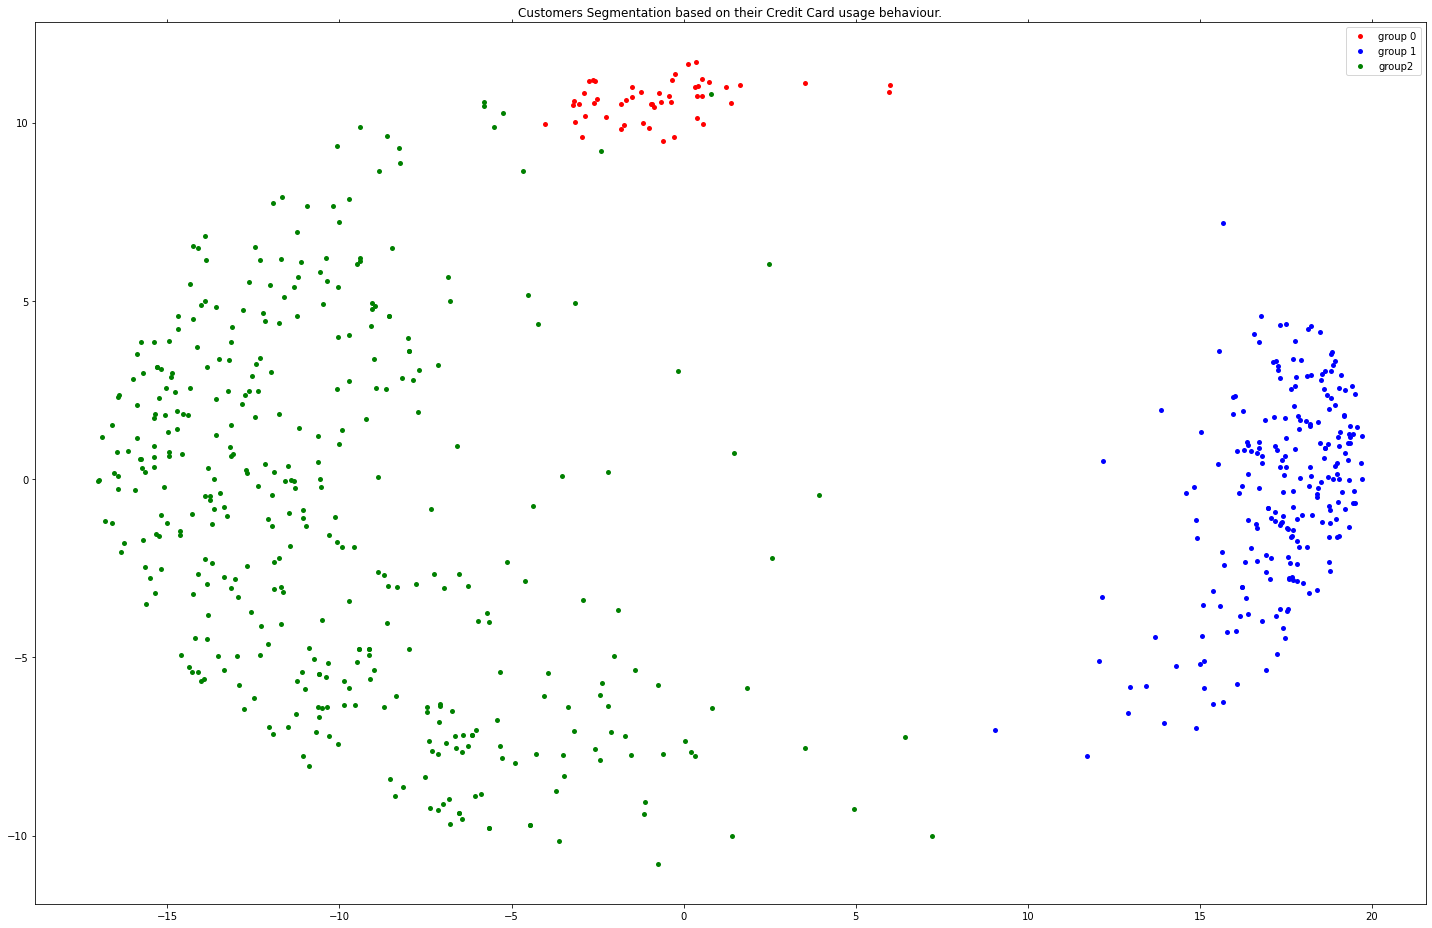

In [57]:
x, y = X_PCA[:, 0], X_PCA[:, 1]
colors = {0: 'red',
          1: 'blue',
          2: 'green'}
names = {0: 'group 0', 
         1: 'group 1', 
         2: 'group2'}    
df_n = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df_n.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage behaviour.")
plt.savefig('pca.png')
plt.show()

